In [2]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils
from nilmtk.dataset_converters.ukdale.convert_ukdale import convert_ukdale

%matplotlib inline
rcParams['figure.figsize'] = (13, 6)

In [155]:
convert_ukdale('ukdale', 'ukdale.h5')

AssertionError: 

In [2]:
train = DataSet('ukdale.h5')
test = DataSet('ukdale.h5')
print('Loaded', len(train.buildings), 'buildings')

Loaded 5 buildings


In [3]:
# elec = data.buildings[2].elec
train.buildings[2].elec.get_timeframe()

TimeFrame(start='2013-02-17 15:39:19+00:00', end='2013-10-10 06:16:00.500000+01:00', empty=False)

In [4]:
train_data = train.buildings[2].elec
test_data = test.buildings[2].elec
mains = train_data.mains()
submeters = train_data.submeters()

In [5]:
elec2 = train.buildings[2].elec
elec2.submeters()

MeterGroup(meters=
  ElecMeter(instance=2, building=2, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1)])
  ElecMeter(instance=3, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer monitor', instance=1)])
  ElecMeter(instance=4, building=2, dataset='UK-DALE', appliances=[Appliance(type='active speaker', instance=1)])
  ElecMeter(instance=5, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer', instance=1)])
  ElecMeter(instance=6, building=2, dataset='UK-DALE', appliances=[Appliance(type='broadband router', instance=1)])
  ElecMeter(instance=7, building=2, dataset='UK-DALE', appliances=[Appliance(type='external hard disk', instance=1)])
  ElecMeter(instance=8, building=2, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])
  ElecMeter(instance=9, building=2, dataset='UK-DALE', appliances=[Appliance(type='rice cooker', instance=1)])
  ElecMeter(instance=10, building=2, dataset='UK-DALE', appliances=[Appliance

In [6]:
list_of_appliances=["dish washer","fridge","laptop computer","computer monitor","active speaker","fridge","microwave","computer","broadband router","external hard disk","fridge","kettle","rice cooker","toaster","games console","fridge","modem","running machine","washing machine","cooker"]

In [7]:
len(list_of_appliances)

20

In [8]:
def train_and_predict_selected_appliances(input_meter,test_elec,test,appliances_chunk):
    classifiers = {'FHMM':FHMM()}
    predictions = {}
    sample_period = 120
    for clf_name, clf in classifiers.items():
        print("*"*20)
        print(clf_name)
        print("*" *20)
        start = time.time()
        # Note that we have given the sample period to downsample the data to 1 minute. 
        # If instead of top_5 we wanted to train on all appliance, we would write 
        # fhmm.train(train_elec, sample_period=60)
        clf.train(input_meter, sample_period=sample_period)
        end = time.time()
        print("Runtime =", end-start, "seconds.")
        gt, predictions[clf_name] = predict_selected_appliances(clf, test_elec, sample_period, test.metadata['timezone'],appliances_chunk)
    return gt, predictions
        
def predict_selected_appliances(clf, test_elec, sample_period, timezone,appliances_chunk):
    pred = {}
    gt= {}
    print(appliances_chunk)
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().select_using_appliances(type=appliances_chunk).meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [9]:
classifiers = {'CO':CombinatorialOptimisation()}
predictions = {}
gt = {}
sample_period = 120
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(submeters, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt_co, predictions_co = predict(clf, test_data, sample_period, train.metadata['timezone'])

********************
CO
********************
Training model for submeter 'ElecMeter(instance=2, building=2, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer monitor', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='UK-DALE', appliances=[Appliance(type='active speaker', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='UK-DALE', appliances=[Appliance(type='broadband router', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=2, dataset='UK-DALE', appliances=[Appliance(type='external hard disk', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='UK-DALE', appliances=[Applia

In [10]:
pred=[]
ground_truth= []
for i in range(0, len(list_of_appliances), 5):
    train_elec = []
    print(list_of_appliances[i:i+5])
    appliances_chunk= list_of_appliances[i:i+5]
    train_elec.append(elec2.submeters().select_using_appliances(type=appliances_chunk))
    train = []
    for item in train_elec:
        for meter in item.meters:
            train.append(meter)
    
    input_meter = MeterGroup(train)
    print(input_meter)
    gt_fhmm, predictions_fhmm=train_and_predict_selected_appliances(input_meter, test_data, test,appliances_chunk)
    pred.append(predictions_fhmm)
    ground_truth.append(gt_fhmm)

['dish washer', 'fridge', 'laptop computer', 'computer monitor', 'active speaker']
MeterGroup(meters=
  ElecMeter(instance=13, building=2, dataset='UK-DALE', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=14, building=2, dataset='UK-DALE', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=2, building=2, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1)])
  ElecMeter(instance=11, building=2, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=2)])
  ElecMeter(instance=3, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer monitor', instance=1)])
  ElecMeter(instance=4, building=2, dataset='UK-DALE', appliances=[Appliance(type='active speaker', instance=1)])
)
********************
FHMM
********************
Training model for submeter 'ElecMeter(instance=13, building=2, dataset='UK-DALE', appliances=[Appliance(type='dish washer', instance=1)])' with 3 states
Training model 

In [11]:
predictions_fhmm = pred[0]['FHMM']
gt_df = ground_truth[0]
for i in range(1,len(pred)):
    predictions_fhmm = predictions_fhmm.merge(pred[i]["FHMM"], left_index=True, right_index=True)
    gt_df = gt_df.merge(ground_truth[i], left_index=True, right_index=True)

In [12]:
gt_co

,"ElecMeter(instance=2, building=2, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1)])","ElecMeter(instance=3, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer monitor', instance=1)])","ElecMeter(instance=4, building=2, dataset='UK-DALE', appliances=[Appliance(type='active speaker', instance=1)])","ElecMeter(instance=5, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer', instance=1)])","ElecMeter(instance=6, building=2, dataset='UK-DALE', appliances=[Appliance(type='broadband router', instance=1)])","ElecMeter(instance=7, building=2, dataset='UK-DALE', appliances=[Appliance(type='external hard disk', instance=1)])","ElecMeter(instance=8, building=2, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])","ElecMeter(instance=9, building=2, dataset='UK-DALE', appliances=[Appliance(type='rice cooker', instance=1)])","ElecMeter(instance=10, building=2, dataset='UK-DALE', appliances=[Appliance(type='running machine', instance=1)])","ElecMeter(instance=11, building=2, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=2)])","ElecMeter(instance=12, building=2, dataset='UK-DALE', appliances=[Appliance(type='washing machine', instance=1)])","ElecMeter(instance=13, building=2, dataset='UK-DALE', appliances=[Appliance(type='dish washer', instance=1)])","ElecMeter(instance=14, building=2, dataset='UK-DALE', appliances=[Appliance(type='fridge', instance=1)])","ElecMeter(instance=15, building=2, dataset='UK-DALE', appliances=[Appliance(type='microwave', instance=1)])","ElecMeter(instance=16, building=2, dataset='UK-DALE', appliances=[Appliance(type='toaster', instance=1)])","ElecMeter(instance=17, building=2, dataset='UK-DALE', appliances=[Appliance(type='games console', instance=1)])","ElecMeter(instance=18, building=2, dataset='UK-DALE', appliances=[Appliance(type='modem', instance=1)])","ElecMeter(instance=19, building=2, dataset='UK-DALE', appliances=[Appliance(type='cooker', instance=1)])"
2013-05-20 22:28:00+01:00,16.428572,60.846153,10.714286,12.928572,6.071429,10.928572,1.00,1.00,1.0,0.0,3.000000,1.000000,11.000000,0.0,0.307692,1.000000,9.000000,0.0
2013-05-20 22:30:00+01:00,17.315790,60.799999,10.789474,12.947369,6.052631,10.947369,1.00,1.00,1.0,0.0,3.200000,1.000000,10.947369,0.0,0.350000,0.950000,9.000000,0.0
2013-05-20 22:32:00+01:00,15.050000,61.736843,10.736842,12.950000,6.100000,10.850000,0.90,1.00,1.0,0.0,3.263158,0.850000,10.950000,0.0,0.263158,0.789474,9.000000,0.0
2013-05-20 22:34:00+01:00,14.421053,60.950001,10.700000,13.105263,6.157895,11.000000,1.00,0.95,1.0,0.0,3.250000,1.000000,10.684211,0.0,0.500000,1.000000,9.052631,0.0
2013-05-20 22:36:00+01:00,14.600000,60.842106,10.578947,13.200000,6.150000,11.052631,0.95,1.00,1.0,0.0,3.105263,0.950000,10.900000,0.0,0.210526,0.789474,9.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-10-10 06:06:00+01:00,0.000000,0.000000,3.157895,14.842105,6.526316,0.000000,1.00,1.00,1.0,0.0,3.578947,0.894737,10.631579,0.0,0.263158,1.000000,9.052631,0.0
2013-10-10 06:08:00+01:00,0.000000,0.000000,3.000000,14.150000,6.000000,0.000000,1.00,1.00,1.0,0.0,3.700000,0.950000,11.000000,0.0,0.250000,1.000000,9.050000,0.0
2013-10-10 06:10:00+01:00,0.000000,0.000000,3.000000,14.000000,6.263158,0.000000,1.00,1.00,1.0,0.0,3.526316,0.894737,11.000000,0.0,0.157895,0.950000,9.000000,0.0
2013-10-10 06:12:00+01:00,0.000000,0.000000,3.000000,14.000000,6.050000,0.000000,0.90,1.00,1.0,0.0,3.631579,0.894737,11.000000,0.0,0.263158,1.000000,9.052631,0.0


In [13]:
appliance_labels_CO = [m.label() for m in gt_co.columns.values]

In [14]:
predictions_fhmm

,"ElecMeter(instance=13, building=2, dataset='UK-DALE', appliances=[Appliance(type='dish washer', instance=1)])","ElecMeter(instance=14, building=2, dataset='UK-DALE', appliances=[Appliance(type='fridge', instance=1)])_x","ElecMeter(instance=2, building=2, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1)])","ElecMeter(instance=11, building=2, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=2)])","ElecMeter(instance=3, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer monitor', instance=1)])","ElecMeter(instance=4, building=2, dataset='UK-DALE', appliances=[Appliance(type='active speaker', instance=1)])","ElecMeter(instance=14, building=2, dataset='UK-DALE', appliances=[Appliance(type='fridge', instance=1)])_y","ElecMeter(instance=15, building=2, dataset='UK-DALE', appliances=[Appliance(type='microwave', instance=1)])","ElecMeter(instance=5, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer', instance=1)])","ElecMeter(instance=6, building=2, dataset='UK-DALE', appliances=[Appliance(type='broadband router', instance=1)])",...,"ElecMeter(instance=14, building=2, dataset='UK-DALE', appliances=[Appliance(type='fridge', instance=1)])_x","ElecMeter(instance=8, building=2, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])","ElecMeter(instance=9, building=2, dataset='UK-DALE', appliances=[Appliance(type='rice cooker', instance=1)])","ElecMeter(instance=16, building=2, dataset='UK-DALE', appliances=[Appliance(type='toaster', instance=1)])","ElecMeter(instance=17, building=2, dataset='UK-DALE', appliances=[Appliance(type='games console', instance=1)])","ElecMeter(instance=14, building=2, dataset='UK-DALE', appliances=[Appliance(type='fridge', instance=1)])_y","ElecMeter(instance=18, building=2, dataset='UK-DALE', appliances=[Appliance(type='modem', instance=1)])","ElecMeter(instance=10, building=2, dataset='UK-DALE', appliances=[Appliance(type='running machine', instance=1)])","ElecMeter(instance=12, building=2, dataset='UK-DALE', appliances=[Appliance(type='washing machine', instance=1)])","ElecMeter(instance=19, building=2, dataset='UK-DALE', appliances=[Appliance(type='cooker', instance=1)])"
2013-05-20 22:28:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,90.0,37.0,29.0,20.0,...,90.0,1.0,3.0,81.0,20.0,11.0,7.0,242.0,1.0,0.0
2013-05-20 22:30:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,90.0,37.0,29.0,20.0,...,90.0,1.0,3.0,81.0,20.0,11.0,7.0,242.0,1.0,0.0
2013-05-20 22:32:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,90.0,37.0,29.0,20.0,...,90.0,1.0,3.0,81.0,20.0,11.0,7.0,242.0,1.0,0.0
2013-05-20 22:34:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,90.0,37.0,29.0,20.0,...,90.0,1.0,3.0,81.0,20.0,11.0,7.0,242.0,1.0,0.0
2013-05-20 22:36:00+01:00,78.0,90.0,29.0,23.0,61.0,10.0,90.0,37.0,309.0,20.0,...,54.0,1.0,381.0,0.0,20.0,90.0,9.0,242.0,3.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-10-10 06:06:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,11.0,37.0,29.0,20.0,...,90.0,1.0,1.0,0.0,20.0,90.0,9.0,2.0,3.0,0.0
2013-10-10 06:08:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,11.0,37.0,29.0,20.0,...,90.0,1.0,1.0,0.0,20.0,90.0,9.0,2.0,3.0,0.0
2013-10-10 06:10:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,11.0,37.0,29.0,20.0,...,90.0,1.0,1.0,0.0,20.0,90.0,9.0,2.0,3.0,0.0
2013-10-10 06:12:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,11.0,37.0,29.0,20.0,...,90.0,1.0,1.0,0.0,20.0,90.0,9.0,2.0,3.0,0.0


In [15]:
gt_co.columns = appliance_labels_CO
predictions_co.columns = appliance_labels_CO

In [16]:
list_of_appliances=["Dish washer","Fridge","Laptop computer","Laptop computer","Computer monitor","Active speaker","Fridge_1","Microwave","Computer","Broadband router","External hard disk","Fridge_1","Kettle","Rice cooker","Toaster","Games console","Fridge_1" ,"Modem","Running machine","Washing machine","Cooker"]

In [17]:
len(list_of_appliances)

21

In [18]:
len(predictions_fhmm.columns)

21

In [19]:
predictions_fhmm.columns = list_of_appliances

In [20]:
gt_co

,Laptop computer,Computer monitor,Active speaker,Computer,Broadband router,External hard disk,Kettle,Rice cooker,Running machine,Laptop computer,Washing machine,Dish washer,Fridge,Microwave,Toaster,Games console,Modem,Cooker
2013-05-20 22:28:00+01:00,16.428572,60.846153,10.714286,12.928572,6.071429,10.928572,1.00,1.00,1.0,0.0,3.000000,1.000000,11.000000,0.0,0.307692,1.000000,9.000000,0.0
2013-05-20 22:30:00+01:00,17.315790,60.799999,10.789474,12.947369,6.052631,10.947369,1.00,1.00,1.0,0.0,3.200000,1.000000,10.947369,0.0,0.350000,0.950000,9.000000,0.0
2013-05-20 22:32:00+01:00,15.050000,61.736843,10.736842,12.950000,6.100000,10.850000,0.90,1.00,1.0,0.0,3.263158,0.850000,10.950000,0.0,0.263158,0.789474,9.000000,0.0
2013-05-20 22:34:00+01:00,14.421053,60.950001,10.700000,13.105263,6.157895,11.000000,1.00,0.95,1.0,0.0,3.250000,1.000000,10.684211,0.0,0.500000,1.000000,9.052631,0.0
2013-05-20 22:36:00+01:00,14.600000,60.842106,10.578947,13.200000,6.150000,11.052631,0.95,1.00,1.0,0.0,3.105263,0.950000,10.900000,0.0,0.210526,0.789474,9.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-10-10 06:06:00+01:00,0.000000,0.000000,3.157895,14.842105,6.526316,0.000000,1.00,1.00,1.0,0.0,3.578947,0.894737,10.631579,0.0,0.263158,1.000000,9.052631,0.0
2013-10-10 06:08:00+01:00,0.000000,0.000000,3.000000,14.150000,6.000000,0.000000,1.00,1.00,1.0,0.0,3.700000,0.950000,11.000000,0.0,0.250000,1.000000,9.050000,0.0
2013-10-10 06:10:00+01:00,0.000000,0.000000,3.000000,14.000000,6.263158,0.000000,1.00,1.00,1.0,0.0,3.526316,0.894737,11.000000,0.0,0.157895,0.950000,9.000000,0.0
2013-10-10 06:12:00+01:00,0.000000,0.000000,3.000000,14.000000,6.050000,0.000000,0.90,1.00,1.0,0.0,3.631579,0.894737,11.000000,0.0,0.263158,1.000000,9.052631,0.0


In [21]:
predictions_fhmm

,Dish washer,Fridge,Laptop computer,Laptop computer,Computer monitor,Active speaker,Fridge_1,Microwave,Computer,Broadband router,...,Fridge_1,Kettle,Rice cooker,Toaster,Games console,Fridge_1,Modem,Running machine,Washing machine,Cooker
2013-05-20 22:28:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,90.0,37.0,29.0,20.0,...,90.0,1.0,3.0,81.0,20.0,11.0,7.0,242.0,1.0,0.0
2013-05-20 22:30:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,90.0,37.0,29.0,20.0,...,90.0,1.0,3.0,81.0,20.0,11.0,7.0,242.0,1.0,0.0
2013-05-20 22:32:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,90.0,37.0,29.0,20.0,...,90.0,1.0,3.0,81.0,20.0,11.0,7.0,242.0,1.0,0.0
2013-05-20 22:34:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,90.0,37.0,29.0,20.0,...,90.0,1.0,3.0,81.0,20.0,11.0,7.0,242.0,1.0,0.0
2013-05-20 22:36:00+01:00,78.0,90.0,29.0,23.0,61.0,10.0,90.0,37.0,309.0,20.0,...,54.0,1.0,381.0,0.0,20.0,90.0,9.0,242.0,3.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-10-10 06:06:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,11.0,37.0,29.0,20.0,...,90.0,1.0,1.0,0.0,20.0,90.0,9.0,2.0,3.0,0.0
2013-10-10 06:08:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,11.0,37.0,29.0,20.0,...,90.0,1.0,1.0,0.0,20.0,90.0,9.0,2.0,3.0,0.0
2013-10-10 06:10:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,11.0,37.0,29.0,20.0,...,90.0,1.0,1.0,0.0,20.0,90.0,9.0,2.0,3.0,0.0
2013-10-10 06:12:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,11.0,37.0,29.0,20.0,...,90.0,1.0,1.0,0.0,20.0,90.0,9.0,2.0,3.0,0.0


In [22]:
predictions_fhmm = predictions_fhmm.drop(columns=["Fridge_1"])

In [23]:
predictions_fhmm

,Dish washer,Fridge,Laptop computer,Laptop computer,Computer monitor,Active speaker,Microwave,Computer,Broadband router,External hard disk,Kettle,Rice cooker,Toaster,Games console,Modem,Running machine,Washing machine,Cooker
2013-05-20 22:28:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,37.0,29.0,20.0,11.0,1.0,3.0,81.0,20.0,7.0,242.0,1.0,0.0
2013-05-20 22:30:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,37.0,29.0,20.0,11.0,1.0,3.0,81.0,20.0,7.0,242.0,1.0,0.0
2013-05-20 22:32:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,37.0,29.0,20.0,11.0,1.0,3.0,81.0,20.0,7.0,242.0,1.0,0.0
2013-05-20 22:34:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,37.0,29.0,20.0,11.0,1.0,3.0,81.0,20.0,7.0,242.0,1.0,0.0
2013-05-20 22:36:00+01:00,78.0,90.0,29.0,23.0,61.0,10.0,37.0,309.0,20.0,11.0,1.0,381.0,0.0,20.0,9.0,242.0,3.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-10-10 06:06:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,37.0,29.0,20.0,11.0,1.0,1.0,0.0,20.0,9.0,2.0,3.0,0.0
2013-10-10 06:08:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,37.0,29.0,20.0,11.0,1.0,1.0,0.0,20.0,9.0,2.0,3.0,0.0
2013-10-10 06:10:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,37.0,29.0,20.0,11.0,1.0,1.0,0.0,20.0,9.0,2.0,3.0,0.0
2013-10-10 06:12:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,37.0,29.0,20.0,11.0,1.0,1.0,0.0,20.0,9.0,2.0,3.0,0.0


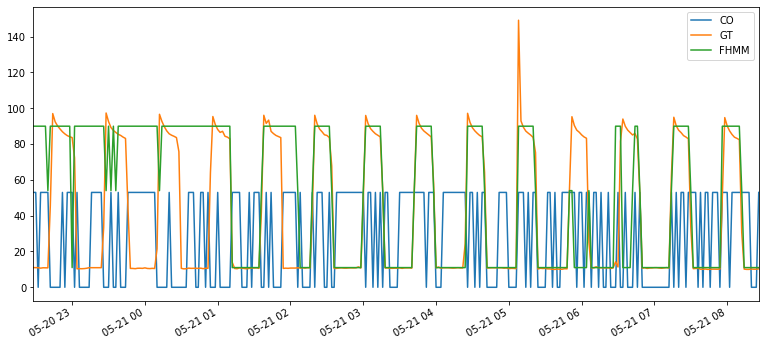

In [24]:
predictions_co['Fridge'].head(300).plot(label="CO")
gt_co['Fridge'].head(300).plot(label="GT")
predictions_fhmm['Fridge'].head(300).plot(label="FHMM")
plt.legend()

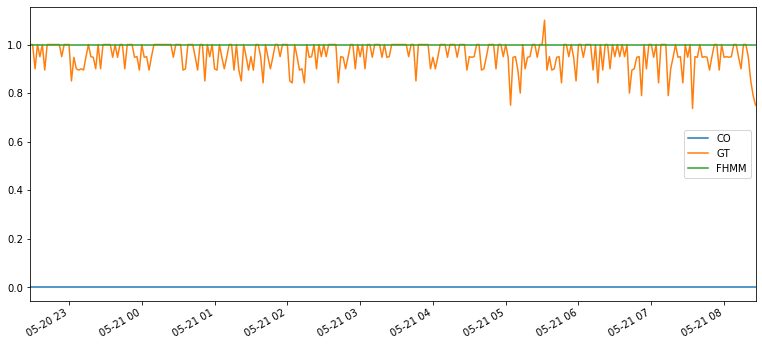

In [25]:
predictions_co['Kettle'].head(300).plot(label="CO")
gt_co['Kettle'].head(300).plot(label="GT")
predictions_fhmm['Kettle'].head(300).plot(label="FHMM")
plt.legend()

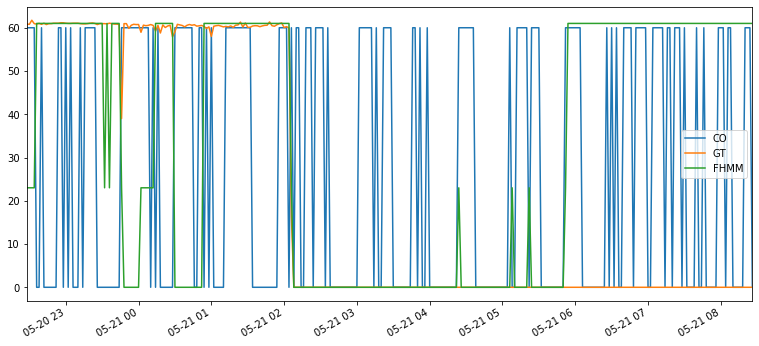

In [26]:
predictions_co['Computer monitor'].head(300).plot(label="CO")
gt_co['Computer monitor'].head(300).plot(label="GT")
predictions_fhmm['Computer monitor'].head(300).plot(label="FHMM")
plt.legend()

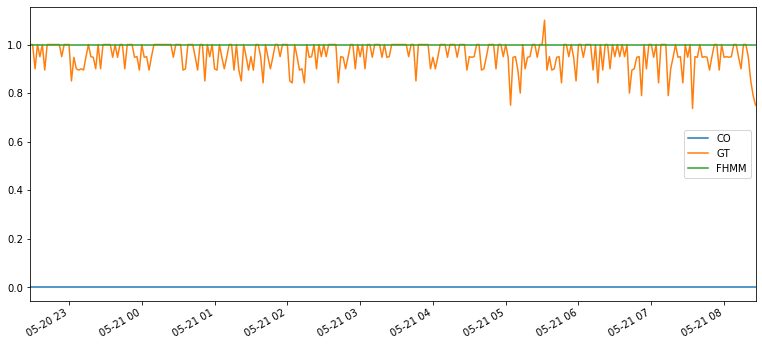

In [27]:
predictions_co['Kettle'].head(300).plot(label="CO")
gt_co['Kettle'].head(300).plot(label="GT")
predictions_fhmm['Kettle'].head(300).plot(label="FHMM")
plt.legend()

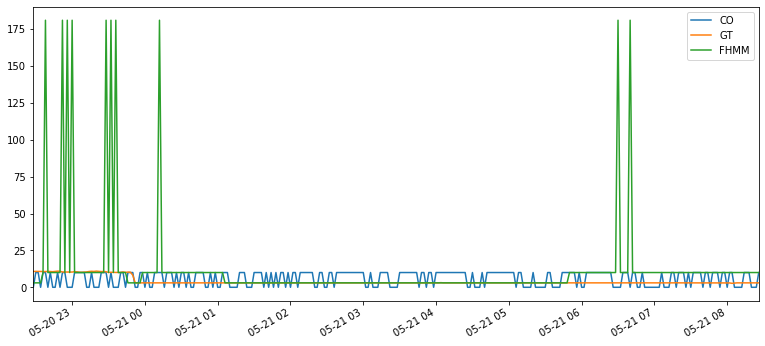

In [28]:
predictions_co['Active speaker'].head(300).plot(label="CO")
gt_co['Active speaker'].head(300).plot(label="GT")
predictions_fhmm['Active speaker'].head(300).plot(label="FHMM")
plt.legend()

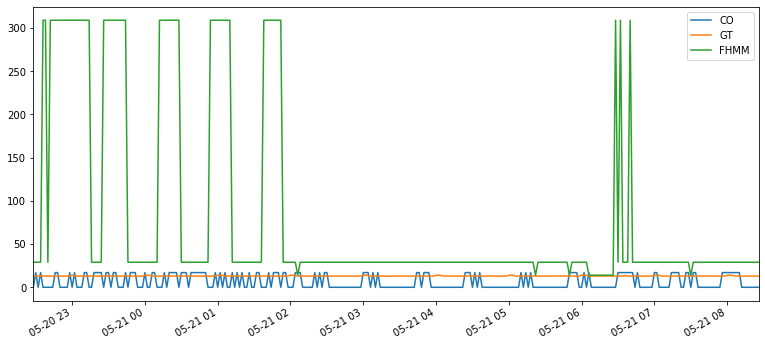

In [29]:
predictions_co['Computer'].head(300).plot(label="CO")
gt_co['Computer'].head(300).plot(label="GT")
predictions_fhmm['Computer'].head(300).plot(label="FHMM")
plt.legend()

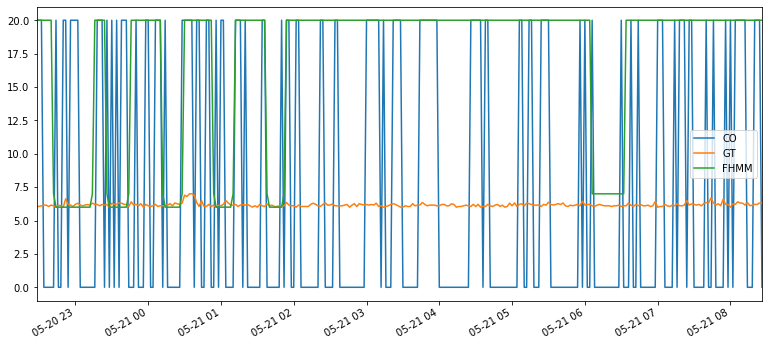

In [30]:
predictions_co['Broadband router'].head(300).plot(label="CO")
gt_co['Broadband router'].head(300).plot(label="GT")
predictions_fhmm['Broadband router'].head(300).plot(label="FHMM")
plt.legend()

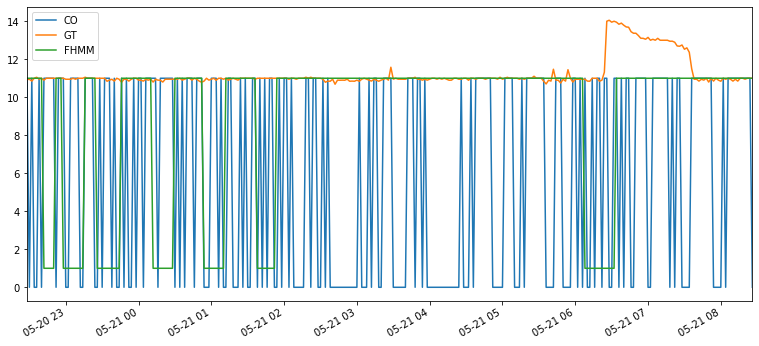

In [31]:
predictions_co['External hard disk'].head(300).plot(label="CO")
gt_co['External hard disk'].head(300).plot(label="GT")
predictions_fhmm['External hard disk'].head(300).plot(label="FHMM")
plt.legend()

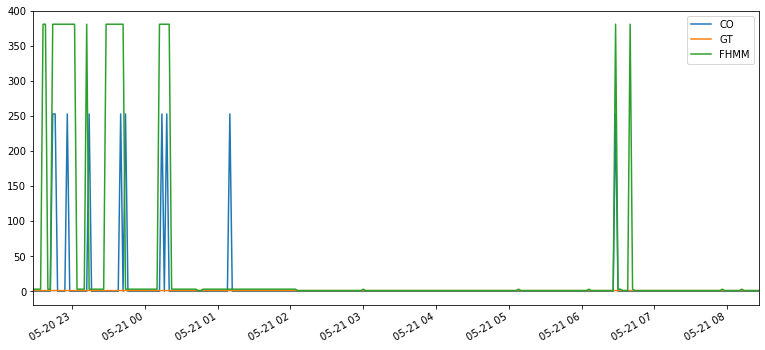

In [32]:
predictions_co['Rice cooker'].head(300).plot(label="CO")
gt_co['Rice cooker'].head(300).plot(label="GT")
predictions_fhmm['Rice cooker'].head(300).plot(label="FHMM")
plt.legend()

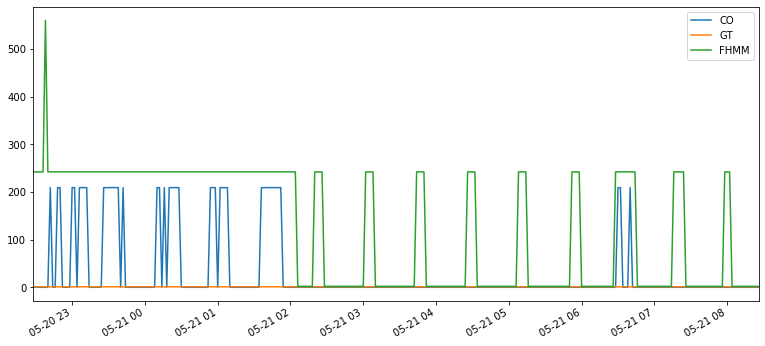

In [33]:
predictions_co['Running machine'].head(300).plot(label="CO")
gt_co['Running machine'].head(300).plot(label="GT")
predictions_fhmm['Running machine'].head(300).plot(label="FHMM")
plt.legend()

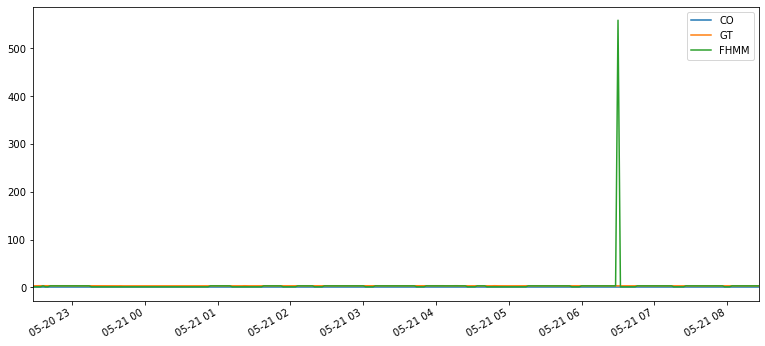

In [34]:
predictions_co['Washing machine'].head(300).plot(label="CO")
gt_co['Washing machine'].head(300).plot(label="GT")
predictions_fhmm['Washing machine'].head(300).plot(label="FHMM")
plt.legend()

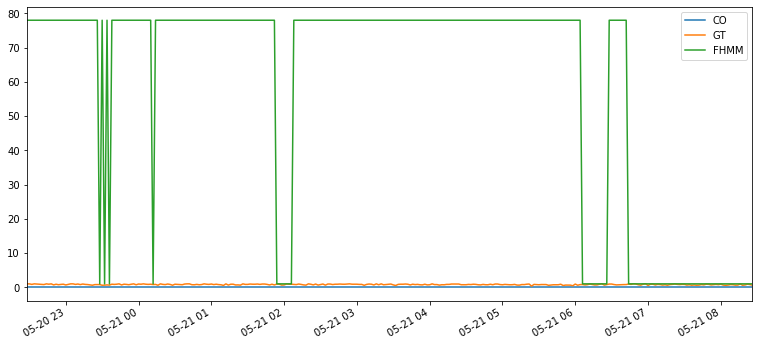

In [35]:
predictions_co['Dish washer'].head(300).plot(label="CO")
gt_co['Dish washer'].head(300).plot(label="GT")
predictions_fhmm['Dish washer'].head(300).plot(label="FHMM")
plt.legend()

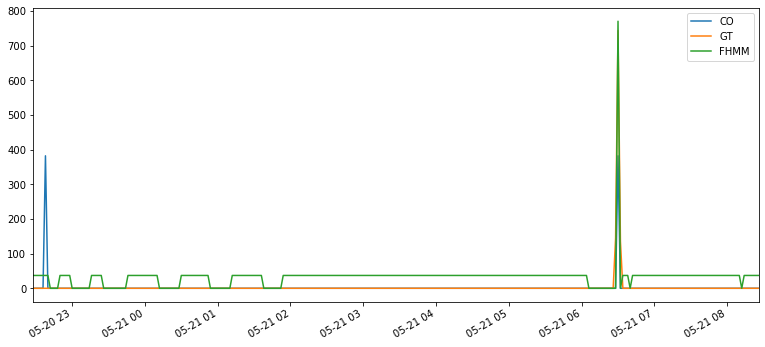

In [36]:
predictions_co['Microwave'].head(300).plot(label="CO")
gt_co['Microwave'].head(300).plot(label="GT")
predictions_fhmm['Microwave'].head(300).plot(label="FHMM")
plt.legend()

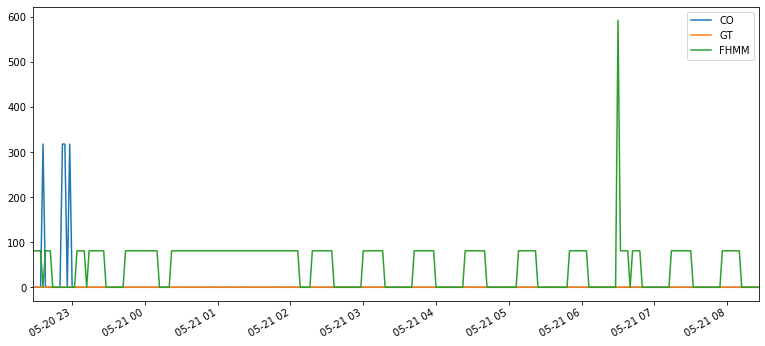

In [37]:
predictions_co['Toaster'].head(300).plot(label="CO")
gt_co['Toaster'].head(300).plot(label="GT")
predictions_fhmm['Toaster'].head(300).plot(label="FHMM")
plt.legend()

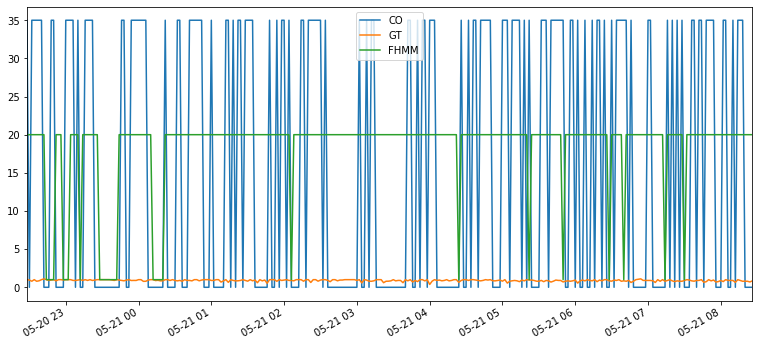

In [38]:
predictions_co['Games console'].head(300).plot(label="CO")
gt_co['Games console'].head(300).plot(label="GT")
predictions_fhmm['Games console'].head(300).plot(label="FHMM")
plt.legend()

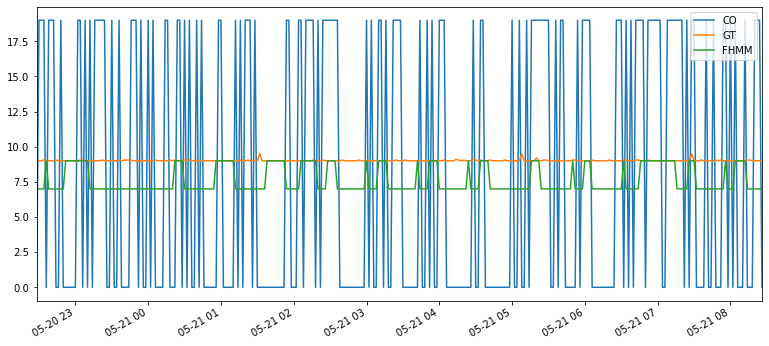

In [39]:
predictions_co['Modem'].head(300).plot(label="CO")
gt_co['Modem'].head(300).plot(label="GT")
predictions_fhmm['Modem'].head(300).plot(label="FHMM")
plt.legend()

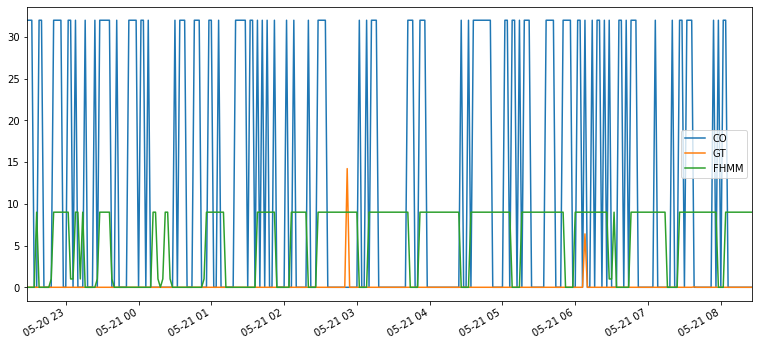

In [40]:
predictions_co['Cooker'].head(300).plot(label="CO")
gt_co['Cooker'].head(300).plot(label="GT")
predictions_fhmm['Cooker'].head(300).plot(label="FHMM")
plt.legend()

In [41]:
predictions_fhmm.index.name="Date"
predictions_co.index.name="Date"
gt_co.index.name="Date"

In [42]:
predictions_co.to_csv("Final_Deliverables/Building_2_predictions_CO.csv")
predictions_fhmm.to_csv("Final_Deliverables/Building_2_predictions_FHMM.csv")
gt_co.to_csv("Final_Deliverables/Building_2_ground_truth.csv")

In [43]:
def convert_to_on_off(curr):
    if float(curr)==0.0: 
        return 0.0 
    elif float(curr)>0: 
        return 1.0
    
def convert_to_on_off_gt(curr, mean_value):
    if float(curr)<float(mean_value): 
        return 0.0 
    elif float(curr)>=float(mean_value): 
        return 1.0
    
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

In [44]:
predictions_co = predictions_co.rename(columns=lambda x: x.replace(' ', '_'))
predictions_fhmm = predictions_fhmm.rename(columns=lambda x: x.replace(' ', '_'))
gt_co = gt_co.rename(columns=lambda x: x.replace(' ', '_'))
predictions_co = df_column_uniquify(predictions_co)
predictions_fhmm = df_column_uniquify(predictions_fhmm)
gt_co = df_column_uniquify(gt_co)
gt_co

,Laptop_computer,Computer_monitor,Active_speaker,Computer,Broadband_router,External_hard_disk,Kettle,Rice_cooker,Running_machine,Laptop_computer_1,Washing_machine,Dish_washer,Fridge,Microwave,Toaster,Games_console,Modem,Cooker
Date,,,,,,,,,,,,,,,,,,
2013-05-20 22:28:00+01:00,16.428572,60.846153,10.714286,12.928572,6.071429,10.928572,1.00,1.00,1.0,0.0,3.000000,1.000000,11.000000,0.0,0.307692,1.000000,9.000000,0.0
2013-05-20 22:30:00+01:00,17.315790,60.799999,10.789474,12.947369,6.052631,10.947369,1.00,1.00,1.0,0.0,3.200000,1.000000,10.947369,0.0,0.350000,0.950000,9.000000,0.0
2013-05-20 22:32:00+01:00,15.050000,61.736843,10.736842,12.950000,6.100000,10.850000,0.90,1.00,1.0,0.0,3.263158,0.850000,10.950000,0.0,0.263158,0.789474,9.000000,0.0
2013-05-20 22:34:00+01:00,14.421053,60.950001,10.700000,13.105263,6.157895,11.000000,1.00,0.95,1.0,0.0,3.250000,1.000000,10.684211,0.0,0.500000,1.000000,9.052631,0.0
2013-05-20 22:36:00+01:00,14.600000,60.842106,10.578947,13.200000,6.150000,11.052631,0.95,1.00,1.0,0.0,3.105263,0.950000,10.900000,0.0,0.210526,0.789474,9.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-10-10 06:06:00+01:00,0.000000,0.000000,3.157895,14.842105,6.526316,0.000000,1.00,1.00,1.0,0.0,3.578947,0.894737,10.631579,0.0,0.263158,1.000000,9.052631,0.0
2013-10-10 06:08:00+01:00,0.000000,0.000000,3.000000,14.150000,6.000000,0.000000,1.00,1.00,1.0,0.0,3.700000,0.950000,11.000000,0.0,0.250000,1.000000,9.050000,0.0
2013-10-10 06:10:00+01:00,0.000000,0.000000,3.000000,14.000000,6.263158,0.000000,1.00,1.00,1.0,0.0,3.526316,0.894737,11.000000,0.0,0.157895,0.950000,9.000000,0.0


In [45]:
predictions_fhmm

,Dish_washer,Fridge,Laptop_computer,Laptop_computer_1,Computer_monitor,Active_speaker,Microwave,Computer,Broadband_router,External_hard_disk,Kettle,Rice_cooker,Toaster,Games_console,Modem,Running_machine,Washing_machine,Cooker
Date,,,,,,,,,,,,,,,,,,
2013-05-20 22:28:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,37.0,29.0,20.0,11.0,1.0,3.0,81.0,20.0,7.0,242.0,1.0,0.0
2013-05-20 22:30:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,37.0,29.0,20.0,11.0,1.0,3.0,81.0,20.0,7.0,242.0,1.0,0.0
2013-05-20 22:32:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,37.0,29.0,20.0,11.0,1.0,3.0,81.0,20.0,7.0,242.0,1.0,0.0
2013-05-20 22:34:00+01:00,78.0,90.0,17.0,23.0,23.0,3.0,37.0,29.0,20.0,11.0,1.0,3.0,81.0,20.0,7.0,242.0,1.0,0.0
2013-05-20 22:36:00+01:00,78.0,90.0,29.0,23.0,61.0,10.0,37.0,309.0,20.0,11.0,1.0,381.0,0.0,20.0,9.0,242.0,3.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-10-10 06:06:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,37.0,29.0,20.0,11.0,1.0,1.0,0.0,20.0,9.0,2.0,3.0,0.0
2013-10-10 06:08:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,37.0,29.0,20.0,11.0,1.0,1.0,0.0,20.0,9.0,2.0,3.0,0.0
2013-10-10 06:10:00+01:00,1.0,11.0,0.0,23.0,61.0,10.0,37.0,29.0,20.0,11.0,1.0,1.0,0.0,20.0,9.0,2.0,3.0,0.0


In [46]:
co_status_df = pd.DataFrame()
fhmm_status_df = pd.DataFrame()
gt_status_df = pd.DataFrame()

In [47]:
for column in predictions_co:
    print(column)
    co_status_df[column+'_status']=predictions_co.apply(lambda row: convert_to_on_off(row[column]), axis=1)
    gt_status_df[column+'_status']=gt_co.apply(lambda row: convert_to_on_off_gt(row[column],gt_co[column].mean()), axis=1)
    fhmm_status_df[column+'_status']=predictions_fhmm.apply(lambda row: convert_to_on_off(row[column]), axis=1)

Laptop_computer
Computer_monitor
Active_speaker
Computer
Broadband_router
External_hard_disk
Kettle
Rice_cooker
Running_machine
Laptop_computer_1
Washing_machine
Dish_washer
Fridge
Microwave
Toaster
Games_console
Modem
Cooker


In [48]:
gt_status_df

,Laptop_computer_status,Computer_monitor_status,Active_speaker_status,Computer_status,Broadband_router_status,External_hard_disk_status,Kettle_status,Rice_cooker_status,Running_machine_status,Laptop_computer_1_status,Washing_machine_status,Dish_washer_status,Fridge_status,Microwave_status,Toaster_status,Games_console_status,Modem_status,Cooker_status
Date,,,,,,,,,,,,,,,,,,
2013-05-20 22:28:00+01:00,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2013-05-20 22:30:00+01:00,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-05-20 22:32:00+01:00,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-05-20 22:34:00+01:00,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2013-05-20 22:36:00+01:00,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-10-10 06:06:00+01:00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2013-10-10 06:08:00+01:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2013-10-10 06:10:00+01:00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [49]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [50]:
results=[]
for column in co_status_df:
    dict_app={}
    dict_app["Appliance"]= column.replace('_status','')
    dict_app['Accuracy'] = accuracy_score(co_status_df[column], gt_status_df[column]) 
    dict_app['Precision'] = precision_score(co_status_df[column], gt_status_df[column])
    dict_app['Recall'] = recall_score(co_status_df[column], gt_status_df[column])
    dict_app['F1'] = f1_score(co_status_df[column], gt_status_df[column])
    results.append(dict_app)       
metric_CO = pd.DataFrame(results) 
results=[]
for column in fhmm_status_df:
    dict_app={}
    dict_app["Appliance"]= column.replace('_status','')
    dict_app['Accuracy'] = accuracy_score(fhmm_status_df[column], gt_status_df[column]) 
    dict_app['Precision'] = precision_score(fhmm_status_df[column], gt_status_df[column])
    dict_app['Recall'] = recall_score(fhmm_status_df[column], gt_status_df[column])
    dict_app['F1'] = f1_score(fhmm_status_df[column], gt_status_df[column])
    results.append(dict_app)       
metric_FHMM = pd.DataFrame(results) 

In [51]:
metric_CO

,Appliance,Accuracy,Precision,Recall,F1
0,Laptop_computer,0.421131,0.299221,0.365720,0.329145
1,Computer_monitor,0.452671,0.263443,0.297734,0.279541
2,Active_speaker,0.574936,0.714426,0.548890,0.620813
3,Computer,0.380243,0.297601,0.566300,0.390163
4,Broadband_router,0.433320,0.646102,0.274941,0.385737
5,External_hard_disk,0.540293,0.050259,0.019424,0.028020
6,Kettle,0.986660,0.523313,0.722108,0.606845
7,Rice_cooker,0.937711,0.285888,0.038965,0.068583
8,Running_machine,0.606407,0.348264,0.069080,0.115291
9,Laptop_computer_1,0.414632,0.608063,0.152217,0.243483


In [52]:
metric_FHMM

,Appliance,Accuracy,Precision,Recall,F1
0,Laptop_computer,0.551320,0.917093,0.515338,0.659876
1,Computer_monitor,0.556278,0.952037,0.474840,0.633643
2,Active_speaker,0.487050,1.000000,0.487050,0.655056
3,Computer,0.666179,1.000000,0.666179,0.799649
4,Broadband_router,0.275387,1.000000,0.275387,0.431848
5,External_hard_disk,0.131838,1.000000,0.131838,0.232963
6,Kettle,0.019673,1.000000,0.019673,0.038587
7,Rice_cooker,0.008022,1.000000,0.008022,0.015915
8,Running_machine,0.073638,1.000000,0.073638,0.137175
9,Laptop_computer_1,0.449099,0.853732,0.200239,0.324394


In [53]:
metric_CO.to_csv("CO_metrics.csv")
metric_FHMM.to_csv("FHMM_metrics.csv")

In [54]:
metric_CO

,Appliance,Accuracy,Precision,Recall,F1
0,Laptop_computer,0.421131,0.299221,0.365720,0.329145
1,Computer_monitor,0.452671,0.263443,0.297734,0.279541
2,Active_speaker,0.574936,0.714426,0.548890,0.620813
3,Computer,0.380243,0.297601,0.566300,0.390163
4,Broadband_router,0.433320,0.646102,0.274941,0.385737
5,External_hard_disk,0.540293,0.050259,0.019424,0.028020
6,Kettle,0.986660,0.523313,0.722108,0.606845
7,Rice_cooker,0.937711,0.285888,0.038965,0.068583
8,Running_machine,0.606407,0.348264,0.069080,0.115291
9,Laptop_computer_1,0.414632,0.608063,0.152217,0.243483


In [55]:
metric_df= pd.merge(metric_FHMM, metric_CO, on='Appliance')
metric_df.columns=["Appliance","Accuracy_FHMM","Precision_FHMM","Recall_FHMM","F1_FHMM","Accuracy_CO","Precision_CO","Recall_CO","F1_CO"]

In [56]:
metric_df

,Appliance,Accuracy_FHMM,Precision_FHMM,Recall_FHMM,F1_FHMM,Accuracy_CO,Precision_CO,Recall_CO,F1_CO
0,Laptop_computer,0.551320,0.917093,0.515338,0.659876,0.421131,0.299221,0.365720,0.329145
1,Computer_monitor,0.556278,0.952037,0.474840,0.633643,0.452671,0.263443,0.297734,0.279541
2,Active_speaker,0.487050,1.000000,0.487050,0.655056,0.574936,0.714426,0.548890,0.620813
3,Computer,0.666179,1.000000,0.666179,0.799649,0.380243,0.297601,0.566300,0.390163
4,Broadband_router,0.275387,1.000000,0.275387,0.431848,0.433320,0.646102,0.274941,0.385737
5,External_hard_disk,0.131838,1.000000,0.131838,0.232963,0.540293,0.050259,0.019424,0.028020
6,Kettle,0.019673,1.000000,0.019673,0.038587,0.986660,0.523313,0.722108,0.606845
7,Rice_cooker,0.008022,1.000000,0.008022,0.015915,0.937711,0.285888,0.038965,0.068583
8,Running_machine,0.073638,1.000000,0.073638,0.137175,0.606407,0.348264,0.069080,0.115291
9,Laptop_computer_1,0.449099,0.853732,0.200239,0.324394,0.414632,0.608063,0.152217,0.243483


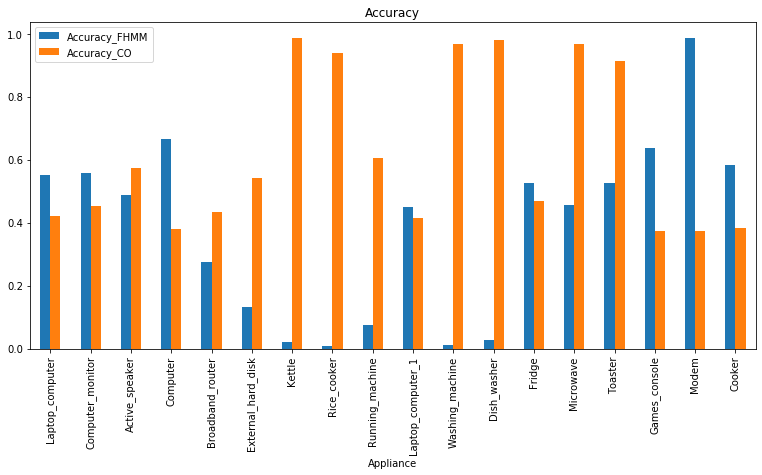

In [57]:
metric_df.plot(x="Appliance", y=["Accuracy_FHMM", "Accuracy_CO"], kind="bar", title='Accuracy')

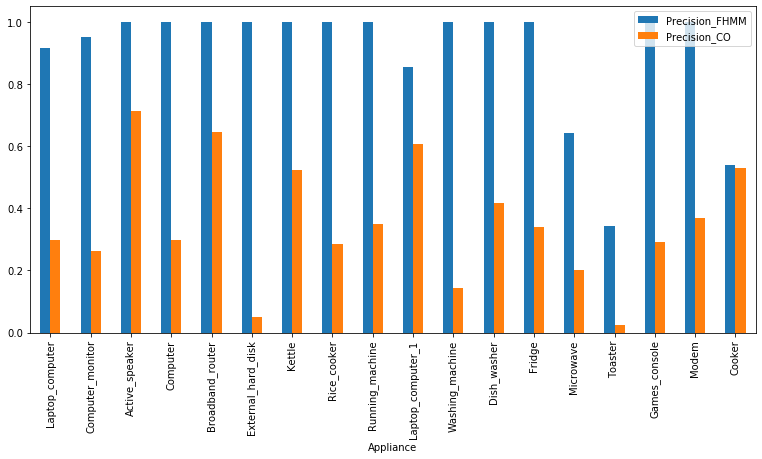

In [58]:
metric_df.plot(x="Appliance", y=["Precision_FHMM", "Precision_CO"], kind="bar")

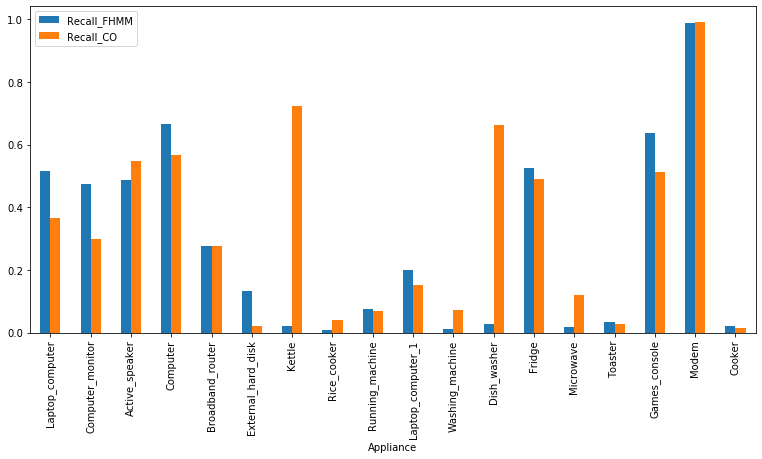

In [59]:
metric_df.plot(x="Appliance", y=["Recall_FHMM", "Recall_CO"], kind="bar")

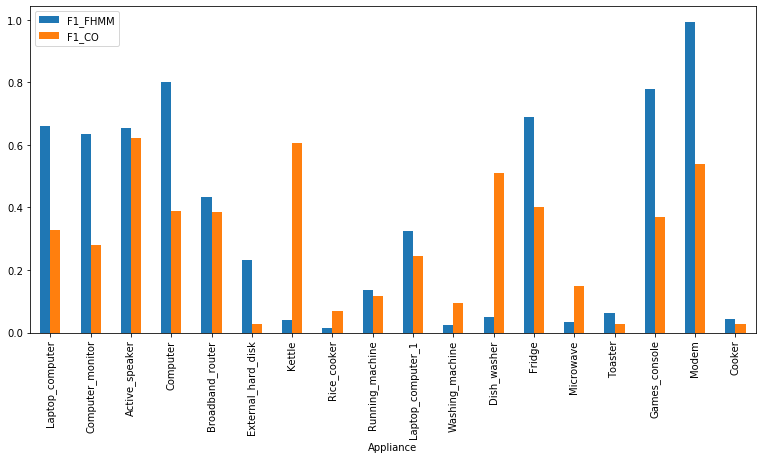

In [60]:
metric_df.plot(x="Appliance", y=["F1_FHMM", "F1_CO"], kind="bar")

In [61]:
import csv
with open('Final_deliverables/Building_2_predictions_FHMM_modified.csv', 'w') as csvwfile:
    with open('Final_Deliverables/Building_2_predictions_FHMM.csv', newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        spamwriter = csv.writer(csvwfile, delimiter=',')
        for row in spamreader:
            row[0]=row[0].replace("+01:00","")
            spamwriter.writerow(row)
with open('Final_deliverables/Building_2_predictions_CO_modified.csv', 'w') as csvwfile:
    with open('Final_Deliverables/Building_2_predictions_CO.csv', newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        spamwriter = csv.writer(csvwfile, delimiter=',')
        for row in spamreader:
            row[0]=row[0].replace("+01:00","")
            spamwriter.writerow(row)
with open('Final_deliverables/Building_2_ground_truth_modified.csv', 'w') as csvwfile:
    with open('Final_Deliverables/Building_2_ground_truth.csv', newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        spamwriter = csv.writer(csvwfile, delimiter=',')
        for row in spamreader:
            row[0]=row[0].replace("+01:00","")
            spamwriter.writerow(row)

In [3]:
FHMM_df = pd.read_csv("Final_deliverables/Building_2_predictions_FHMM_modified.csv", sep=',', parse_dates=['Date'], header=0, index_col="Date")
CO_df = pd.read_csv("Final_deliverables/Building_2_predictions_CO_modified.csv", sep=',', parse_dates=['Date'], header=0, index_col="Date")
GT_df = pd.read_csv("Final_deliverables/Building_2_ground_truth_modified.csv", sep=',', parse_dates=['Date'], header=0, index_col="Date")

In [4]:
nilmtk.utils.compute_rmse

<function nilmtk.utils.compute_rmse(ground_truth, predictions, pretty=True)>

In [5]:
rmse = {}
rmse["CO"] = nilmtk.utils.compute_rmse(GT_df, CO_df)
rmse_co = pd.DataFrame(rmse["CO"])
rmse["CO"] = nilmtk.utils.compute_rmse(GT_df, FHMM_df)
rmse_fhmm = pd.DataFrame(rmse["CO"])
merged_rmse_wo_normalization = rmse_co.merge(rmse_fhmm, left_index= True, right_index = True)
merged_rmse_wo_normalization.columns = ["rmse_co", "rmse_fhmm"]

In [6]:
merged_rmse_wo_normalization

,rmse_co,rmse_fhmm
Laptop computer,18.276993,373.532124
Computer monitor,44.545726,54.847326
Active speaker,5.586237,18.047413
Computer,11.430028,10.748049
Broadband router,11.750615,47.666841
External hard disk,7.150284,47.704668
Kettle,221.175282,280.816671
Rice cooker,64.259656,206.988295
Running machine,127.322539,25.016847
Laptop computer.1,18.546006,10.440585


In [7]:
import pandas as pd
from sklearn import preprocessing

In [8]:
x = CO_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
CO = pd.DataFrame(x_scaled)

x = FHMM_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
FHMM = pd.DataFrame(x_scaled)

x = GT_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
GT = pd.DataFrame(x_scaled)

In [9]:
CO.columns = CO_df.columns
FHMM.columns = FHMM_df.columns
GT.columns = GT_df.columns

In [10]:
rmse = {}
rmse["CO"] = nilmtk.utils.compute_rmse(GT, CO)
rmse_co = pd.DataFrame(rmse["CO"])
rmse["FHMM"] = nilmtk.utils.compute_rmse(GT,FHMM)
rmse_fhmm = pd.DataFrame(rmse["FHMM"])
merged_rmse_normalization = rmse_co.merge(rmse_fhmm, left_index= True, right_index = True)
merged_rmse_normalization.columns = ["rmse_co", "rmse_fhmm"]

In [11]:
merged_rmse_normalization

,rmse_co,rmse_fhmm
Laptop computer,0.592690,0.206004
Computer monitor,0.650495,0.599346
Active speaker,0.592486,0.533596
Computer,0.520534,0.615546
Broadband router,0.707418,0.759827
External hard disk,0.580465,0.262215
Kettle,0.082497,0.185985
Rice cooker,0.244317,0.668279
Running machine,0.608258,0.747884
Laptop computer.1,0.769453,0.696634


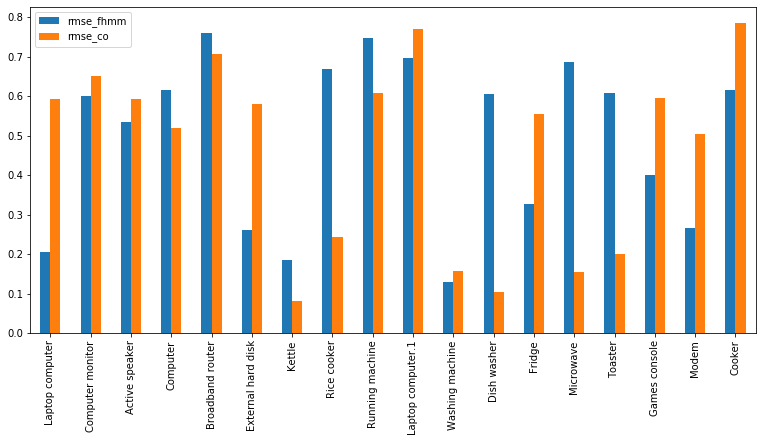

In [12]:
merged_rmse_normalization.plot(y=["rmse_fhmm","rmse_co"], kind="bar")

In [13]:
def to_timestamp(date):
    return time.mktime(time.strptime(date, '%Y-%m-%d %H:%M:%S'))

In [14]:
FHMM_final = FHMM_df.reset_index()
FHMM_final.Date=FHMM_final.apply(lambda row: to_timestamp(str(row.Date)), axis=1)
FHMM_final=FHMM_final.set_index('Date')
FHMM_final

,Dish washer,Fridge,Laptop computer,Laptop computer.1,Computer monitor,Active speaker,Microwave,Computer,Broadband router,External hard disk,Kettle,Rice cooker,Toaster,Games console,Modem,Running machine,Washing machine,Cooker
Date,,,,,,,,,,,,,,,,,,
1.369114e+09,78.0,90.0,17.0,23.0,23.0,3.0,37.0,29.0,20.0,11.0,1.0,3.0,81.0,20.0,7.0,242.0,1.0,0.0
1.369114e+09,78.0,90.0,17.0,23.0,23.0,3.0,37.0,29.0,20.0,11.0,1.0,3.0,81.0,20.0,7.0,242.0,1.0,0.0
1.369114e+09,78.0,90.0,17.0,23.0,23.0,3.0,37.0,29.0,20.0,11.0,1.0,3.0,81.0,20.0,7.0,242.0,1.0,0.0
1.369114e+09,78.0,90.0,17.0,23.0,23.0,3.0,37.0,29.0,20.0,11.0,1.0,3.0,81.0,20.0,7.0,242.0,1.0,0.0
1.369115e+09,78.0,90.0,29.0,23.0,61.0,10.0,37.0,309.0,20.0,11.0,1.0,381.0,0.0,20.0,9.0,242.0,3.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.381410e+09,1.0,11.0,0.0,23.0,61.0,10.0,37.0,29.0,20.0,11.0,1.0,1.0,0.0,20.0,9.0,2.0,3.0,0.0
1.381410e+09,1.0,11.0,0.0,23.0,61.0,10.0,37.0,29.0,20.0,11.0,1.0,1.0,0.0,20.0,9.0,2.0,3.0,0.0
1.381411e+09,1.0,11.0,0.0,23.0,61.0,10.0,37.0,29.0,20.0,11.0,1.0,1.0,0.0,20.0,9.0,2.0,3.0,0.0


In [31]:
channel_number =2
labels = ["Aggregate"]
idx = [1]
for column in FHMM_final.columns:
    FHMM_final[column].to_csv("Building2/channel_"+str(channel_number)+".dat",sep=' ', header=False)
    labels.append(str(column))
    idx.append(channel_number)
    channel_number += 1 

In [32]:
idx

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [33]:
labels_df= pd.DataFrame(labels, index=idx) 

In [34]:
labels_df

,0
1,Aggregate
2,Dish washer
3,Fridge
4,Laptop computer
5,Laptop computer.1
6,Computer monitor
7,Active speaker
8,Microwave
9,Computer
10,Broadband router


In [35]:
labels_df.to_csv("Building2/labels.dat",sep=' ', header=False)